### Instituto Superior de Engenharia de Lisboa

## Classificação e Autenticação Biométrica com sinais de Fotopletismografia (PPG)

#### Data de Entrega: 6 de novembro de 2024

### Alunos:
- Ana Sofia Oliveira (39275)
- Eduardo Santos (40610)

____________________
## Tabela de Conteúdos

- [Configurações Iniciais](#configurações-iniciais)
   * [Imports](#imports)
   * [Funções Auxiliares](#funções-auxiliares)
- [Dataset](#dataset)
- [Filtragem e Segmentação](#filtragem-e-segmentacao)
- [Outlier Detection](#outlier-detection)
- [Template Selection](#template-selection)
- [Domínio do Problema](#domínio-do-problema)
- [Problema Multiclasse](#problema-multiclasse)
   * [Treino](#treino)
   * [Teste](#teste)
   * [Avaliação](#avaliação)
- [Problema Binário](#problema-binário)
   * [Treino](#treino-1)
   * [Teste](#teste-1)
   * [Avaliação](#avaliação-1)

_____________
<a name="configurações-iniciais"></a>

## Configurações Iniciais
Nesta secção são definidas as dependências funcionais e estruturais do projeto. O projeto proposto depende funcionalmente da utilização das bibliotecas importadas na sub-secção Imports, e estruturalmente das funções auxiliares criadas durante o seu desenvolvimento. 

<a name="imports"></a>

### Imports

In [11]:
import os
import wfdb
import pickle
import numpy as np
import random as rd
import matplotlib.pyplot as plt

from biosppy.signals import ppg as bppg
from biosppy.clustering import outliers_dbscan

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Dense, Concatenate

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

<a name="funções-auxiliares"></a>

### Funções Auxiliares

In [ ]:
def outlier_detection(templates, epsilon=0.001, min_samples=15, metric='correlation'):
    try:
        result = outliers_dbscan(data=templates, eps=epsilon, min_samples=min_samples, metric=metric)
        
        outliers = result['templates'][-1]
        valid = result['templates'][0]
        
        return valid, outliers
    
    except Exception as e:
        return None, None


def plotOutlierDetectionDetails(ind_id, templates, valid, outliers): 
    axis = np.linspace(0, 600, 75)

    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Indivíduo {ind_id}")
    plt.subplot(221)
    plt.title(f"{len(templates)} Templates")
    plt.plot(axis, templates.T);
    
    plt.subplot(222)
    plt.title(f"Oultier Detection com DBSCAN")
    plt.plot(axis, valid.T, label='Templates Válidos', color='black');
    plt.plot(axis, outliers.T, label='Outliers', color='red', alpha=0.2);

    plt.subplot(223)
    plt.title(f"{len(valid)} Templates Válidos")
    plt.plot(axis, valid.T, label='Templates Válidos', color='black');

    plt.subplot(224)
    plt.title(f"{len(outliers)} Outliers")
    plt.plot(axis, outliers.T, label='Outliers', color='red');

    plt.tight_layout()
    plt.show()
    
    os.makedirs(f"imgs/ind{ind_id}", exist_ok=True)
    plt.savefig(f"imgs/ind{ind_id}/outlier_detection.png")


def plotSignalDetails(data, nSegundos=10): 
    
    plt.figure(figsize=(12, 6))
    plt.suptitle("Indivíduo " + str(data['subject']))

    plt.subplot(321)
    plt.title(f"Raw Vs Filtrado")
    plt.plot(data['signal']);
    plt.plot(data['f_signal']);
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.legend(["raw", "filtrado"])

    plt.subplot(322)
    plt.title(f" Raw Vs Filtrado ({nSegundos} segundos)")
    plt.plot(data['signal'][:nSegundos*data['fs']]);
    plt.plot(data['f_signal'][:nSegundos*data['fs']]);
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.legend(["raw", "filtrado"])

    plt.subplot(323)
    plt.title(f"Raw templates")
    plt.plot(data['old_templates'].T);
    
    plt.subplot(324)
    plt.title(f"Templates")
    plt.plot(data['templates'].T);

    plt.subplot(325)
    plt.title(f"Templates Válidos")
    plt.plot(data['templates'].T, color='green');

    plt.subplot(326)
    plt.title(f"Outliers")
    plt.plot(data['outliers'].T, color='red');
    
    plt.tight_layout()
    plt.show()

    os.makedirs(f"imgs/ind{data['subject']}", exist_ok=True)
    plt.savefig(f"imgs/ind{data['subject']}/signal.png")


def plotTemplatesHistogram(data, limite=None):
    nTemplates = [len(templates) for templates in [individuo['templates'] for individuo in data]]
    print(f"Mínimo de templates: {np.min(nTemplates)} (indivíduo {data[np.argmin(nTemplates)]['subject']})")
    print(f"Máximo de templates: {np.max(nTemplates)} (indivíduo {data[np.argmax(nTemplates)]['subject']})")
    
    print("Limite: ", limite)
    if limite is not None: 
        min = limite
        max = limite
        mean = limite
    else:
        min = int(np.min(nTemplates))
        max = int(np.max(nTemplates))
        mean = int(np.mean(nTemplates))

    plt.figure(figsize=(12, 6))
    plt.bar([individuo['subject'] for individuo in data], nTemplates);
    plt.axhline(y=min, color='r', linestyle='-.');
    plt.axhline(y=max, color='g', linestyle='-.');
    plt.axhline(y=mean, color='orange', linestyle='-.');
    plt.title('Distribuição de templates por indivíduo')
    plt.xlabel('Indivíduo')
    plt.ylabel('Número de Templates')
    plt.legend([f"Mínimo={min}", f"Máximo={max}", f"Média={mean}", "Número de templates"])
    plt.tight_layout()
    plt.show()
    
    os.makedirs(f"imgs/ind{individuo['subject']}", exist_ok=True)
    plt.savefig(f"imgs/ind{individuo['subject']}/templates_histogram.png")

    return min, max, mean


def plotModelHistory(history, type='multi'):
    # Extract metrics from the history object
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']

    # Number of epochs
    epochs = range(1, len(loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r', label='Training loss');
    plt.plot(epochs, val_loss, 'b', label='Validation loss');
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'r', label='Training accuracy');
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy');
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    os.makedirs(f"imgs", exist_ok=True)
    plt.savefig(f"imgs/{type}_model.png")


def plotConfusionMatrix(true_classes, pred_classes, type='multi'): 
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(true_classes, pred_classes)
    matrix = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(true_classes))
    fig, ax = plt.subplots(figsize=(10,10))
    fig.suptitle('Matriz de confusão do teste', fontsize=20)
    matrix.plot(ax=ax, cmap='viridis');
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    os.makedirs(f"imgs", exist_ok=True)
    plt.savefig(f"imgs/{type}_confusionMatrix.png")


def plotROCCurves(true_classes, pred_classes): 
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(true_classes, pred_classes)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})');
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    os.makedirs(f"imgs", exist_ok=True)
    plt.savefig(f"imgs/rocCurve.png")

______________
<a name="dataset"></a>
## Dataset

O dataset utilizado foi o "BIDMC PPG and Respiration Dataset", na sua primeira versão, da Physionet. 

Este dataset contém sinais e dados numéricos de formas de onda MIMIC II, extraídos do banco de dados, juntamente com as anotações manuais das respirações, realizadas por dois anotadores, utilizando os sinais respiratórios de impedância. 

Os dados foram adquiridos a partir de pacientes hospitalizados em estado crítico no centro médico Beth Israel Deaconess (Boston, MA, EUA), durante o seu atendimento hospitalar, tendo o registo das respirações sido realizado manualmente por dois anotadores, a partir de cada gravação, usando o sinal respiratório de impedância. Cada gravação, com duração de 8 minutos, contém os seguintes dados: 
- Sinais fisiológicos, como PPG, sinal respiratório de impedância e eletrocardiograma (ECG). Estes sinais são amostrados a 125 Hz.
- Parametros fisiológicos, como frequência cardíaca (HR), frequência respiratória (RR) e nível de saturação de oxigênio no sangue (SpO2). Estes são amostrados a 1 Hz. 
- Parametros fixos, como a idade e o género. 
- Anotações manuais da respiração. 

Este dataset disponiliza todos estes dados em formato WFDB (WaveForm DataBase), formato padrão utilizado pela PhysioNet. Sendo que, para cada gravação existem 5 arquivos (onde ## representa o número do sujeito): 
- bidmc##.breath: Anotações manuais de respiração.
- bidmc##.dat: Arquivo de dados de forma de onda.
- bidmc##.hea: Arquivo de cabeçalho de forma de onda.
- bidmc##n.dat: Arquivo de dados numéricos.
- bidmc##n.hea: Arquivo de cabeçalho numérico.

No contexto deste projeto utilizaremos apenas as gravações relativas aos sinais de PPG em forma de onda, ou seja, os registos disponibilizados no ficheiros arquivos bidmc##.dat. 

O dataset foi descarregado e armazenado localmente, tendo sido recolhidas as informações apresentadas no dicionário abaixo: 

```python
data = [
            {
            'subject': id do sujeito (indivíduo), 
            'signal': sinal PPG, 
            'fs': frequência de amostragem do sinal
            }, 
            ...
        ]
```

In [ ]:
def load_dataset(records_folder): 
    with open(f'{records_folder}bidmc-ppg-and-respiration-dataset-1.0.0\RECORDS', 'r') as file:
        records = file.readlines()
        records = [record.strip() for record in records]

    data = []

    for record in records:
        record_name = f"{records_folder}bidmc-ppg-and-respiration-dataset-1.0.0/{record}"
        print("Record name:", record_name)
        try:
            record, fields = wfdb.rdsamp(record_name)

            if ('PLETH,' in fields['sig_name']):
                ppg = record[:,fields['sig_name'].index('PLETH,')]
                fs = fields['fs']
                data.append({'subject': int(record_name[-2:]), 
                                'signal': ppg,
                                'fs': fs})
                print("-> Adicionado sinal do individuo", record_name)
        except Exception as e:
            print("Erro ao adicionar sinal do individuo", record_name, e)

    return data

In [13]:
# records_folder = "../spikes/ppg/"
records_folder = "../ppg/dataset/"

data = load_dataset(records_folder)

Record name: ../ppg/dataset/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc01
-> Adicionado sinal do individuo ../ppg/dataset/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc01
Record name: ../ppg/dataset/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc02
-> Adicionado sinal do individuo ../ppg/dataset/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc02
Record name: ../ppg/dataset/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc03
-> Adicionado sinal do individuo ../ppg/dataset/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc03
Record name: ../ppg/dataset/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc04
-> Adicionado sinal do individuo ../ppg/dataset/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc04
Record name: ../ppg/dataset/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc05
-> Adicionado sinal do individuo ../ppg/dataset/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc05
Record name: ../ppg/dataset/bidmc-ppg-and-respiration-dataset-1.0.0/bidmc06
-> Adicionado sinal do individuo ../ppg/dataset/bidmc-ppg-and-re

O bloco de código abaixo verifica os dados obtidos após o processo de leitura. Podemos verificar que foram lidos dados de 53 indivíduos, com 60000 amostras por sinal ($ \frac{\frac{6000}{125}}{60} = 8 $ minutos ). 

Número de indivíduos: 51
Frequência de amostragem: 125
Duração dos sinais: 480.008 segundos, 8.000 minutos


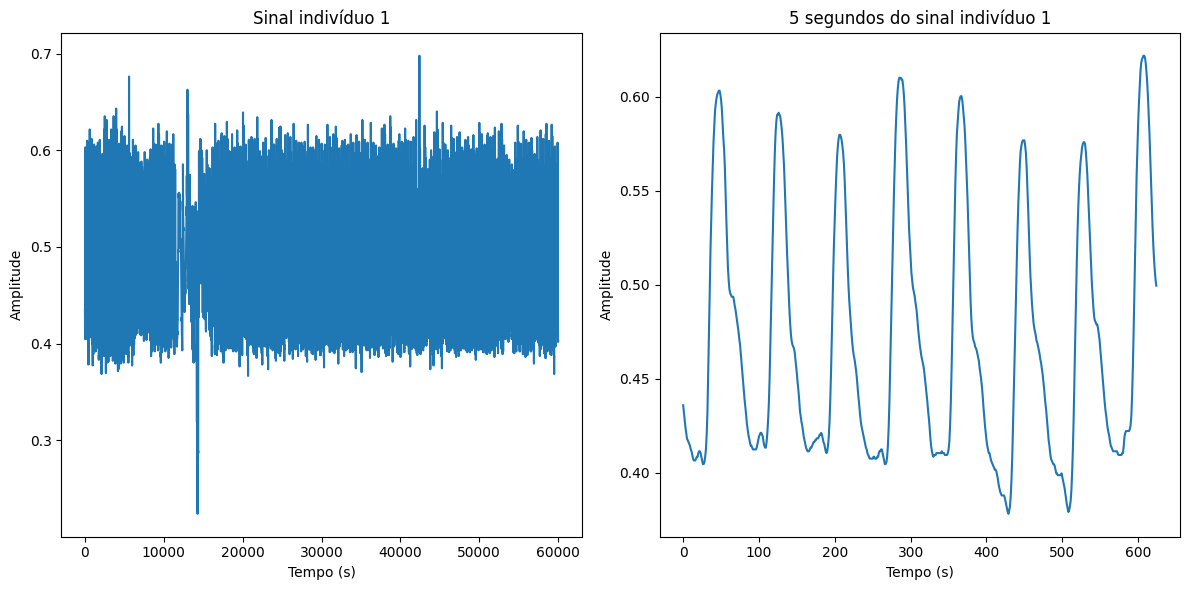

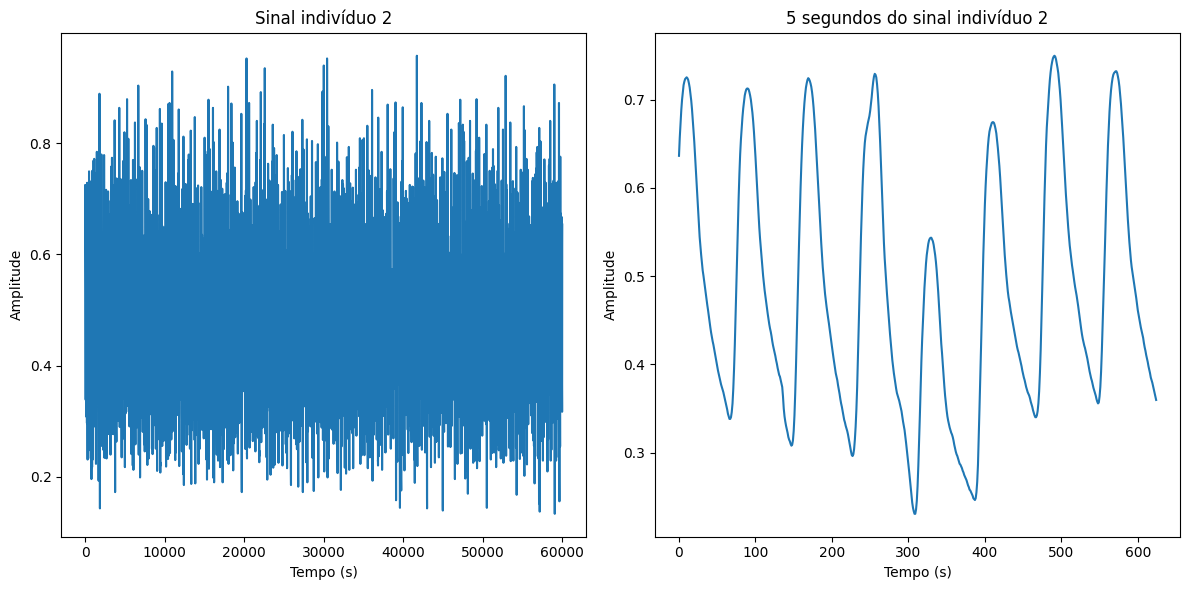

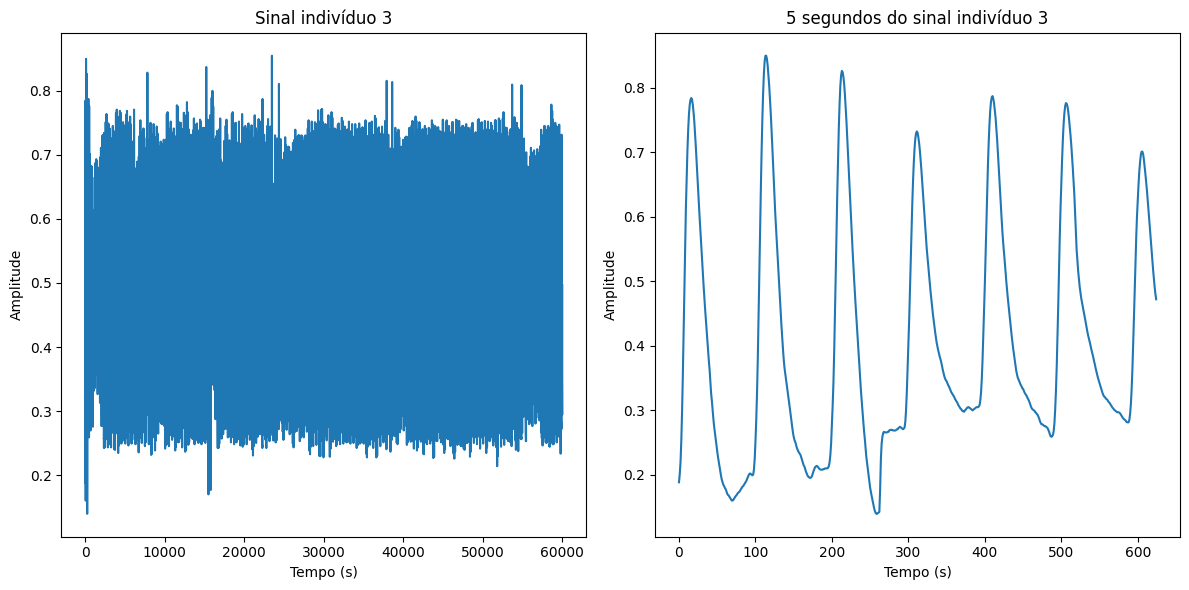

In [14]:
print("Número de indivíduos:", len(data))
print("Frequência de amostragem:", data[0]['fs'])
print(f"Duração dos sinais: {len(data[0]['signal'])/data[0]['fs']:.3f} segundos, {len(data[0]['signal'])/(data[0]['fs']*60):.3f} minutos")

nIndividuos = 3
nSegundos = 5

for nIndividuo in range(nIndividuos):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.title(f"Sinal indivíduo {data[nIndividuo]['subject']}")
    plt.plot(data[nIndividuo]['signal'])
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')

    plt.subplot(122)
    plt.title(f"{nSegundos} segundos do sinal indivíduo {data[nIndividuo]['subject']}")
    plt.plot(data[nIndividuo]['signal'][:nSegundos*data[nIndividuo]['fs']])
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')    
    plt.tight_layout()
    plt.show();

_____________
<a name="pre-processamento"></a>
## Pré-processamento

### Filtragem <a name="filtragem"></a>

In [ ]:
def filtragem(sinal, fs, show=False): 
    return bppg.ppg(signal=signal, sampling_rate=fs, show=show)

### Segmentação <a name="segmentacao"></a>

O sinal PPG é composto por 

O sinal PPG representa uma composição de diversos templates consecutivos. Assim, o processo de segmentação consiste na tradução de um sinal contínuo numa série de templates individuais. Para isso, é necessário identificar os picos do sinal proviniente do dataset. Para a identificação dos picos foi utilizada a biblioteca BioSpy. Através da função ppg.ppg, a biblioteca BioSpy, recebe um sinal de input e a sua frequência de amostragem e devolve o cálculo sinal filtrado. A segmentação dos dados é importante para manter apenas os dados pretendidos O de segmentação dos dados é crítico para



In [ ]:
def segmentation(sinal, picos, fs):

    offset_left = int(200*fs/1000)
    offset_right = int(400*fs/1000)

    templates = np.array([sinal[pico-offset_left:pico+offset_right] for pico in picos[:-1]])

    return templates

## Feature Extraction <a name="feature-extraction"></a>

### Outlier Detection <a name="outlier-detection"></a>



(342, 673)
(674,)
674 (674,)


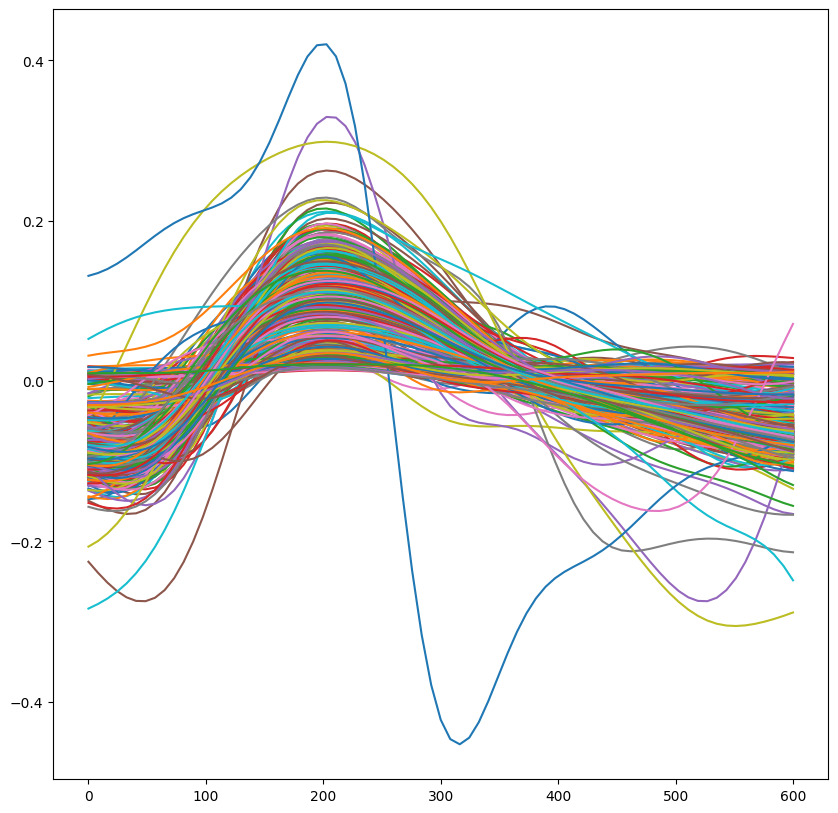

0 0.0009
Número de templates válidos (DBSCAN): 223
Número de templates outliers (DBSCAN): 450


<Figure size 640x480 with 0 Axes>

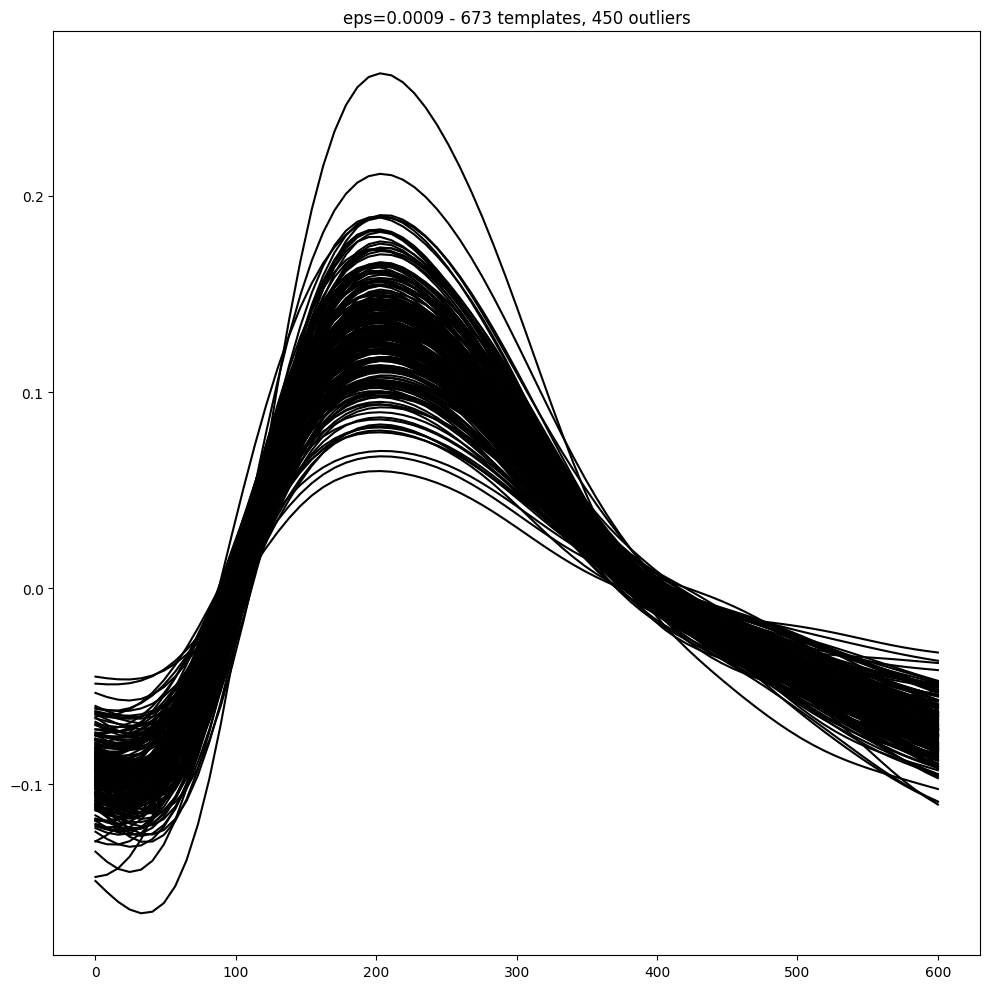

1 0.001
Número de templates válidos (DBSCAN): 244
Número de templates outliers (DBSCAN): 429


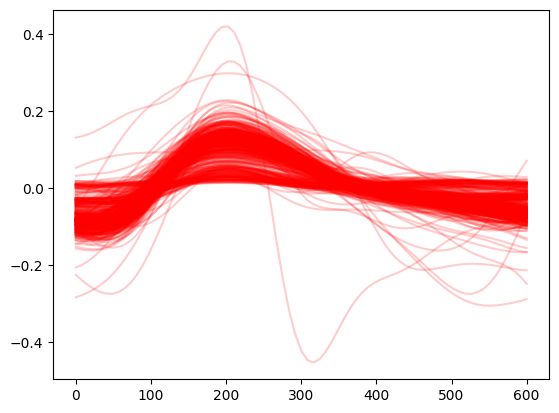

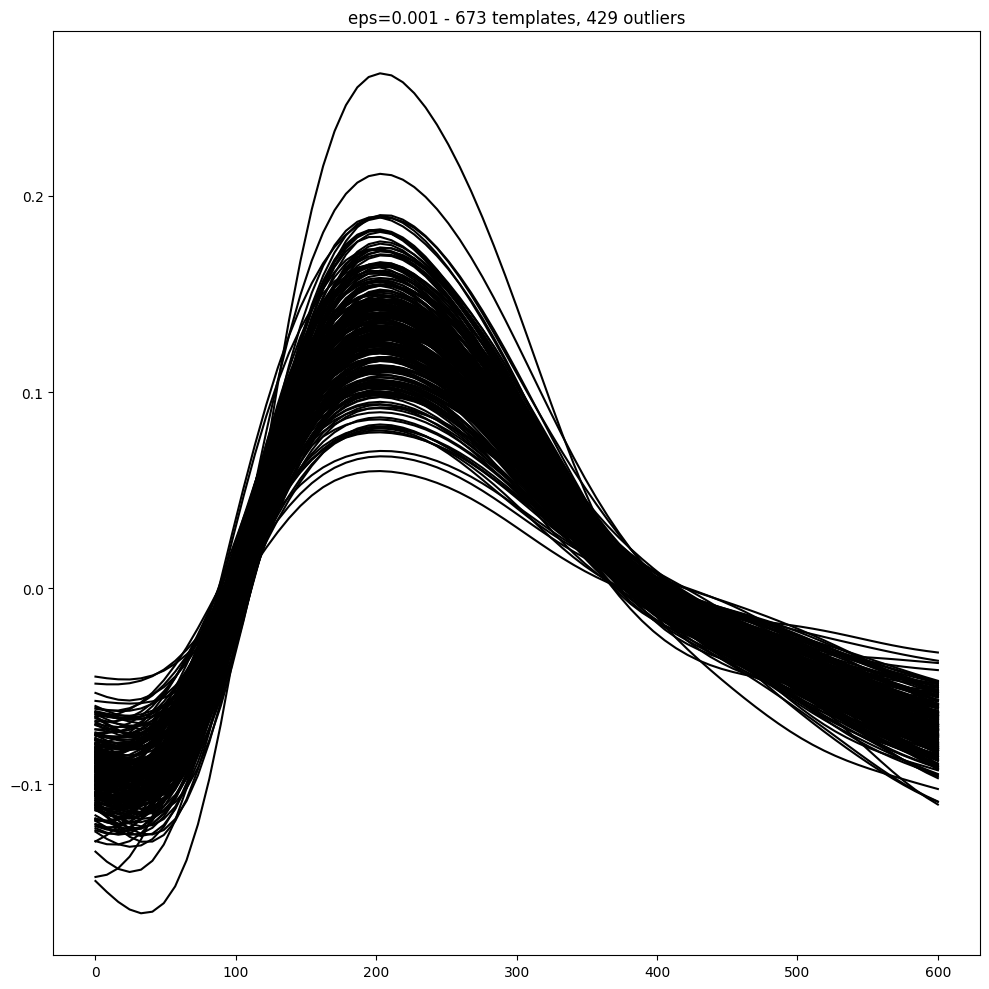

2 0.005
Número de templates válidos (DBSCAN): 507
Número de templates outliers (DBSCAN): 166


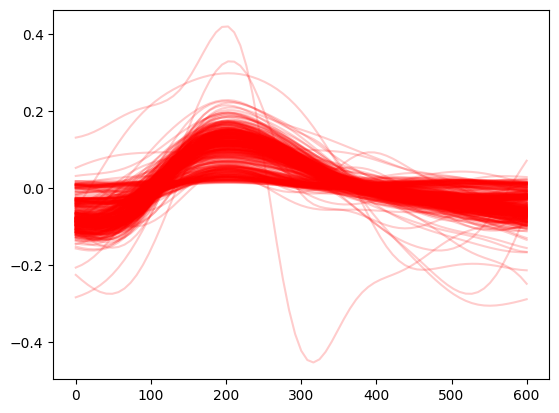

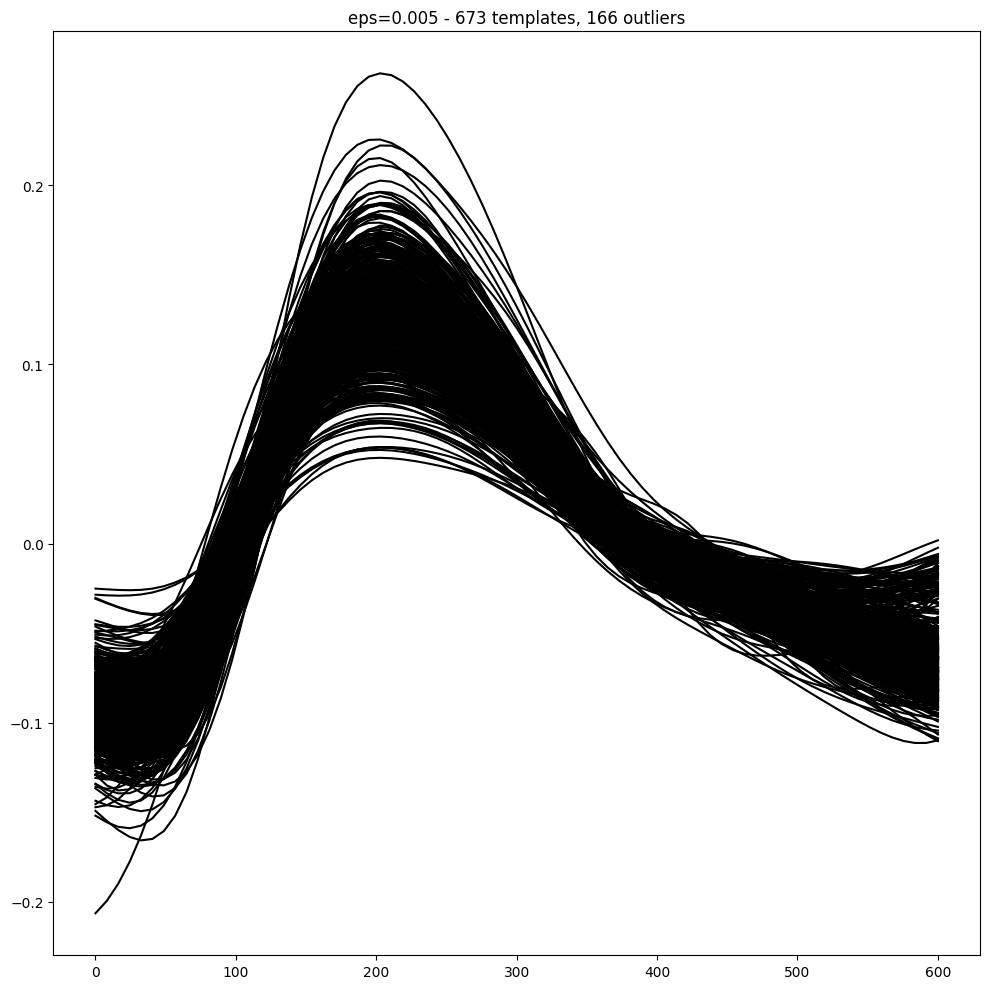

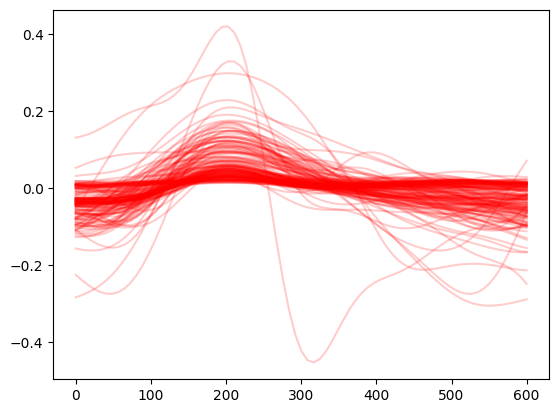

In [15]:
out = bppg.ppg(signal=data[25]['signal'], sampling_rate=data[25]['fs'], show=False)

print(out['templates'].shape)
print(out['peaks'].shape)
filtrado = out['filtered']
picos = out['peaks']

offset_left = int(200*data[25]['fs']/1000)
offset_right = int(400*data[25]['fs']/1000)

print(len(picos), picos.shape)

templates = np.array([filtrado[pico-offset_left:pico+offset_right] for pico in picos[:-1]])

plt.figure(figsize=(10, 10))
axis = np.linspace(0, 600, 75)
# plt.title("Templates individuo X")
plt.plot(axis, templates.T)
plt.show();

os.makedirs(f"imgs/ind{data[25]['subject']}", exist_ok=True)
plt.savefig(f"imgs/ind{data[25]['subject']}/templates.png")


eps = [0.0009, 0.001, 0.005]

for i, e in enumerate(eps): 
    print(i, e)
    result = outliers_dbscan(data=templates, eps=e, min_samples=15, metric='correlation')

    outliers = result['templates'][-1]
    valid = result['templates'][0]
    plt.figure(figsize=(10,10))
    # plt.subplot(1,len(eps),i+1)
    print("Número de templates válidos (DBSCAN):", len(valid))	
    print("Número de templates outliers (DBSCAN):", len(outliers))

    plt.title(f"eps={e} - {len(templates)} templates, {len(outliers)} outliers")
    plt.plot(axis, valid.T, label='Valid', color='black')
    plt.tight_layout()
    plt.show();
    
    plt.plot(axis, outliers.T, label='Outliers', color='red', alpha=0.2)
    plt.savefig(f"imgs/ind{data[25]['subject']}/outliers_eps{e}.png")

<a name="outlier-detection"></a>

## Outlier Detection

Indivíduo 1:
Número total de templates: 718
Indivíduo 2:
Número total de templates: 726
Indivíduo 3:
Número total de templates: 612
Indivíduo 4:
Número total de templates: 719
Indivíduo 5:
Número total de templates: 770
Indivíduo 6:
Número total de templates: 652
Indivíduo 7:
Número total de templates: 719
Indivíduo 8:
Número total de templates: 797
Indivíduo 9:
Número total de templates: 613
Indivíduo 10:
Número total de templates: 655


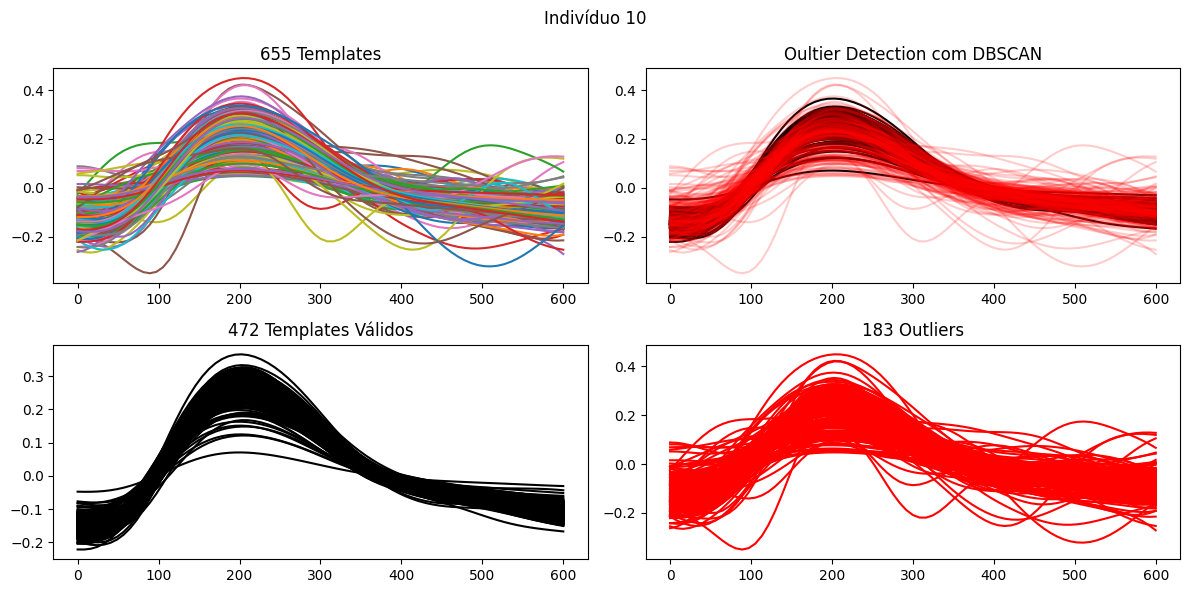

Indivíduo 11:
Número total de templates: 741
Indivíduo 12:
Número total de templates: 741
Indivíduo 13:
Número total de templates: 534
Indivíduo 14:
Número total de templates: 756
Indivíduo 15:
Número total de templates: 856
Indivíduo 16:
Número total de templates: 872
Indivíduo 17:
Número total de templates: 647
Indivíduo 18:
Número total de templates: 719
Indivíduo 21:
Número total de templates: 984
Indivíduo 22:
Número total de templates: 651
Indivíduo 23:
Número total de templates: 512
Indivíduo 24:
Número total de templates: 761
Indivíduo 25:
Número total de templates: 969
Indivíduo 26:
Número total de templates: 673
Indivíduo 27:
Número total de templates: 702
Indivíduo 30:
Número total de templates: 703


<Figure size 640x480 with 0 Axes>

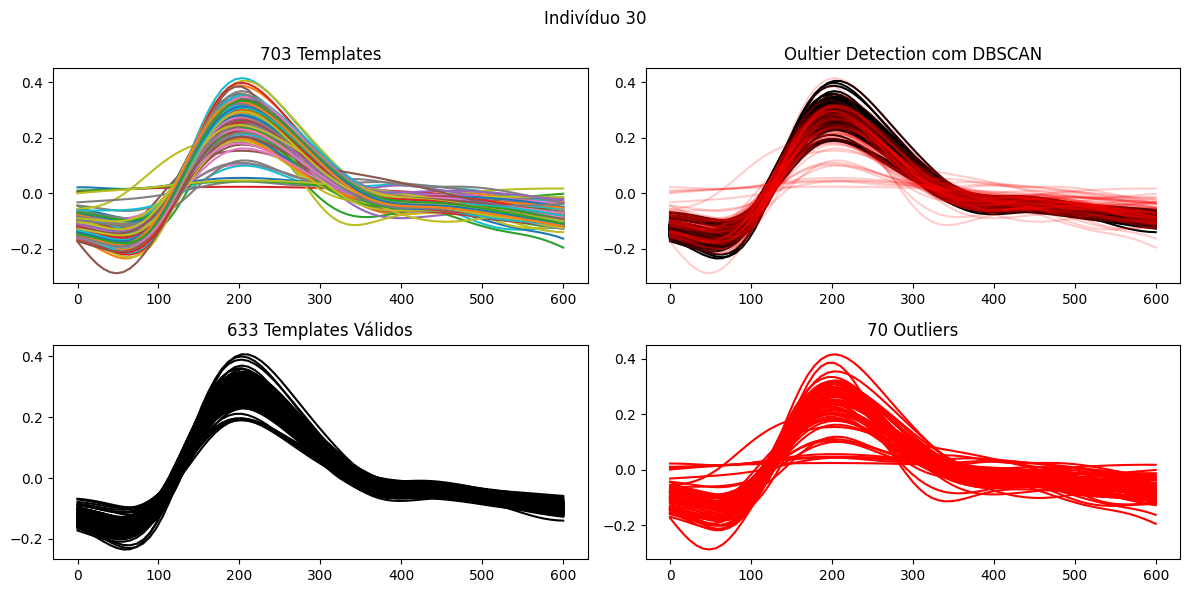

Indivíduo 31:
Número total de templates: 667
Indivíduo 32:
Número total de templates: 647
Indivíduo 33:
Número total de templates: 673
Indivíduo 34:
Número total de templates: 650
Indivíduo 35:
Número total de templates: 806
Indivíduo 36:
Número total de templates: 581
Indivíduo 37:
Número total de templates: 718
Indivíduo 38:
Número total de templates: 667
Indivíduo 39:
Número total de templates: 604
Indivíduo 40:
Número total de templates: 813


<Figure size 640x480 with 0 Axes>

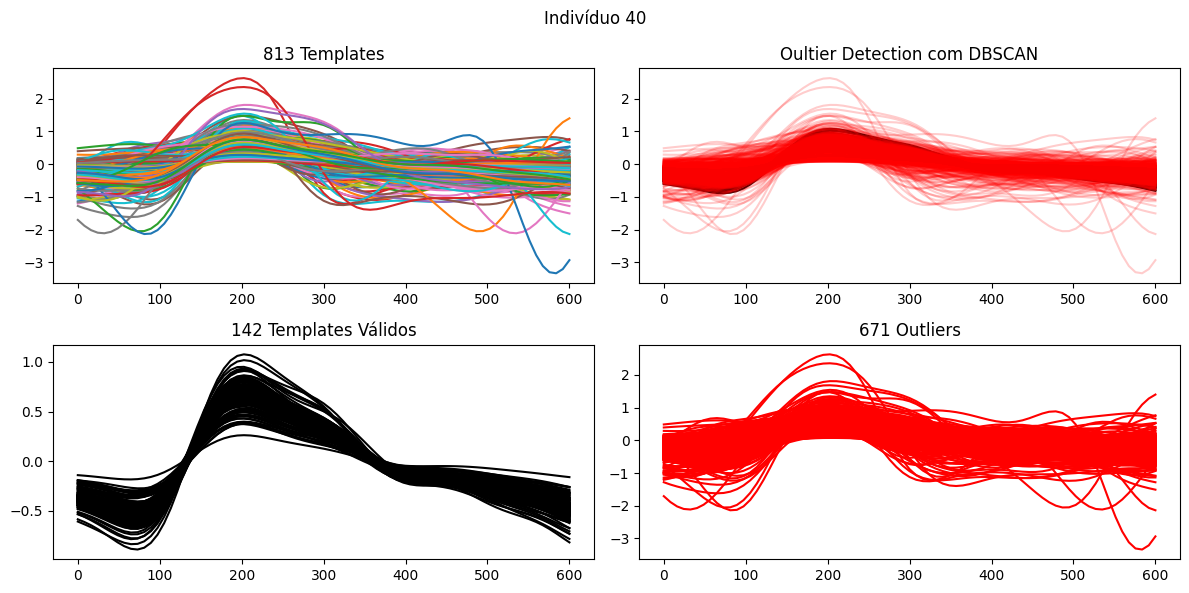

Indivíduo 41:
Número total de templates: 693
Indivíduo 42:
Número total de templates: 668
Indivíduo 43:
Número total de templates: 717
Indivíduo 45:
Número total de templates: 562
Indivíduo 46:
Número total de templates: 852
Indivíduo 47:
Número total de templates: 670
Indivíduo 48:
Número total de templates: 801
Indivíduo 49:
Número total de templates: 678
Indivíduo 50:
Número total de templates: 611


<Figure size 640x480 with 0 Axes>

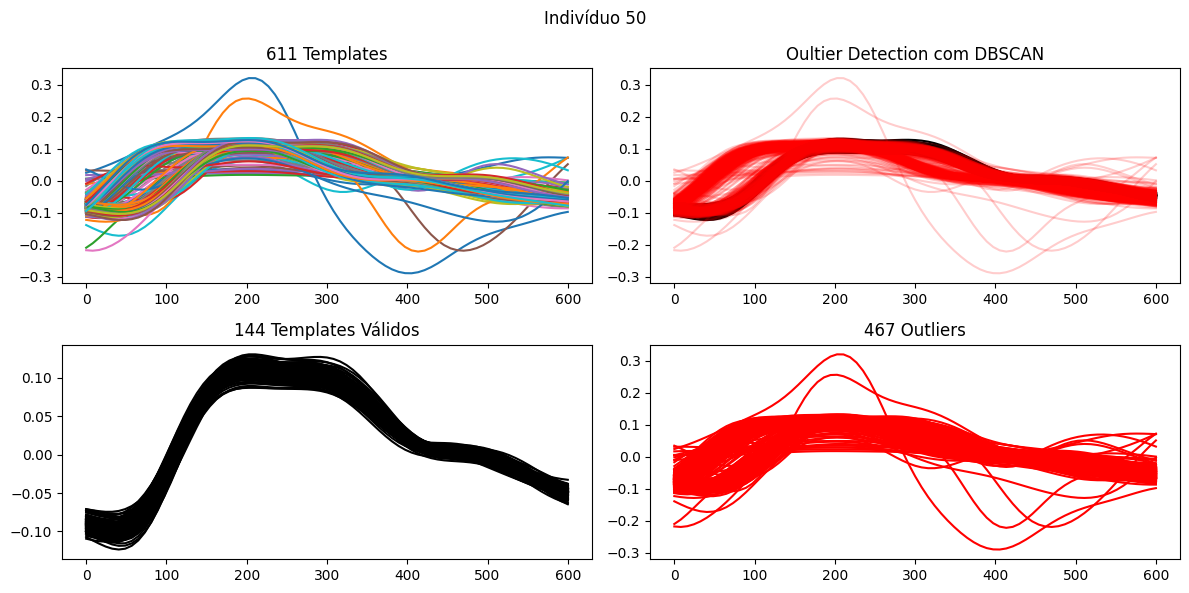

Indivíduo 51:
Número total de templates: 719
Indivíduo 52:
Número total de templates: 919
Indivíduo 53:
Número total de templates: 727


<Figure size 640x480 with 0 Axes>

In [ ]:
SHOW_OUTLIER_DETECTION_DETAILS = True

for individuo in data: 
    signal = individuo['signal']
    fs = individuo['fs']

    out = filtragem(sinal, fs, show=False)

    templates = segmentation(out['filtered'], out['peaks'], fs) 

    print(f"Indivíduo {individuo['subject']}:")
    print(f"Número total de templates: {len(templates)}")

    try:
        valid, outliers = outlier_detection(templates)

        if SHOW_OUTLIER_DETECTION_DETAILS:
            if (individuo['subject'] % 10 == 0):
                plotOutlierDetectionDetails(individuo['subject'], templates, valid, outliers)

        individuo.update({'f_signal': out['filtered'], 
                 'peaks': out['peaks'], 
                 'old_templates': templates,
                 'templates': valid, 
                 'outliers': outliers, 
                 'data_index': data.index(individuo)
                 })

    except Exception as e:
        data.remove(individuo)
        print(f"Erro ao processar os templates do indivíduo {individuo['subject']}: {e}")


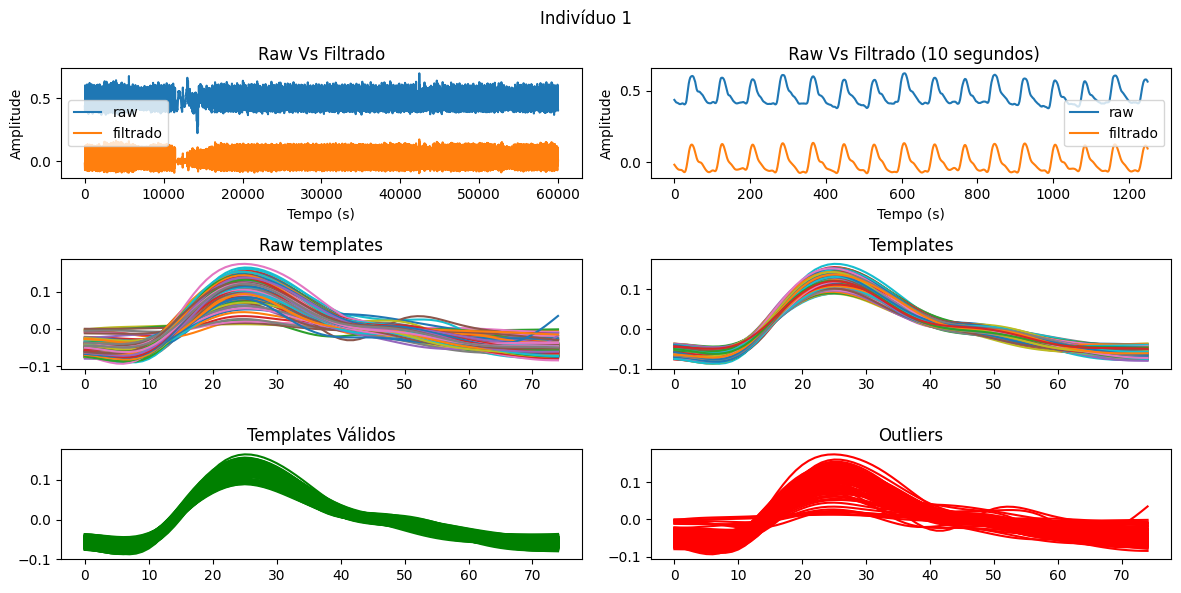

<Figure size 640x480 with 0 Axes>

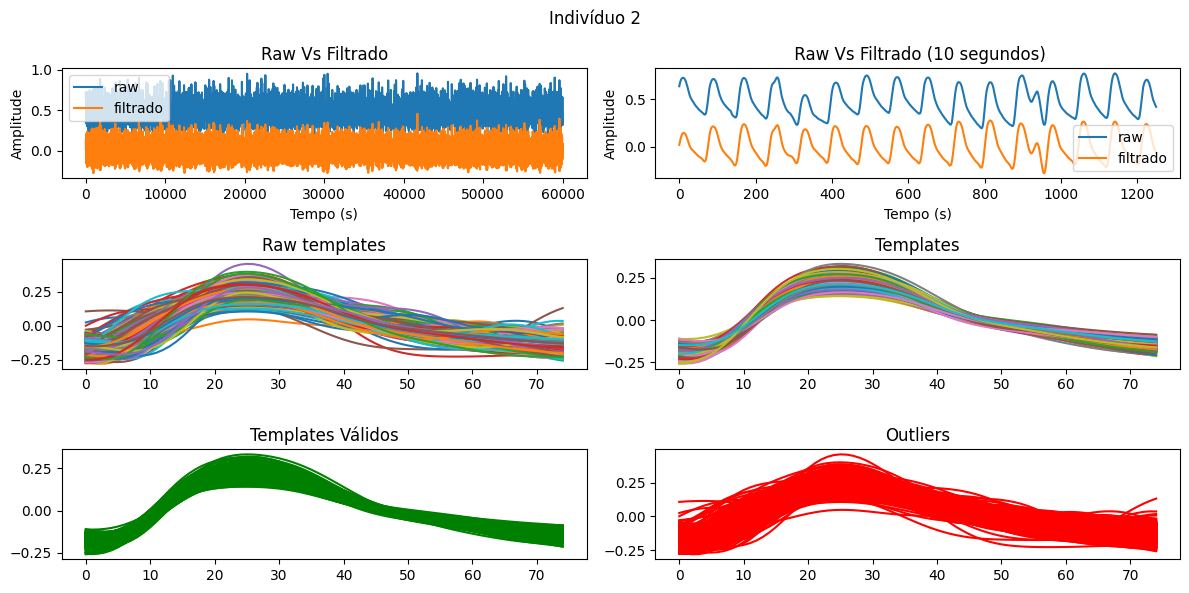

<Figure size 640x480 with 0 Axes>

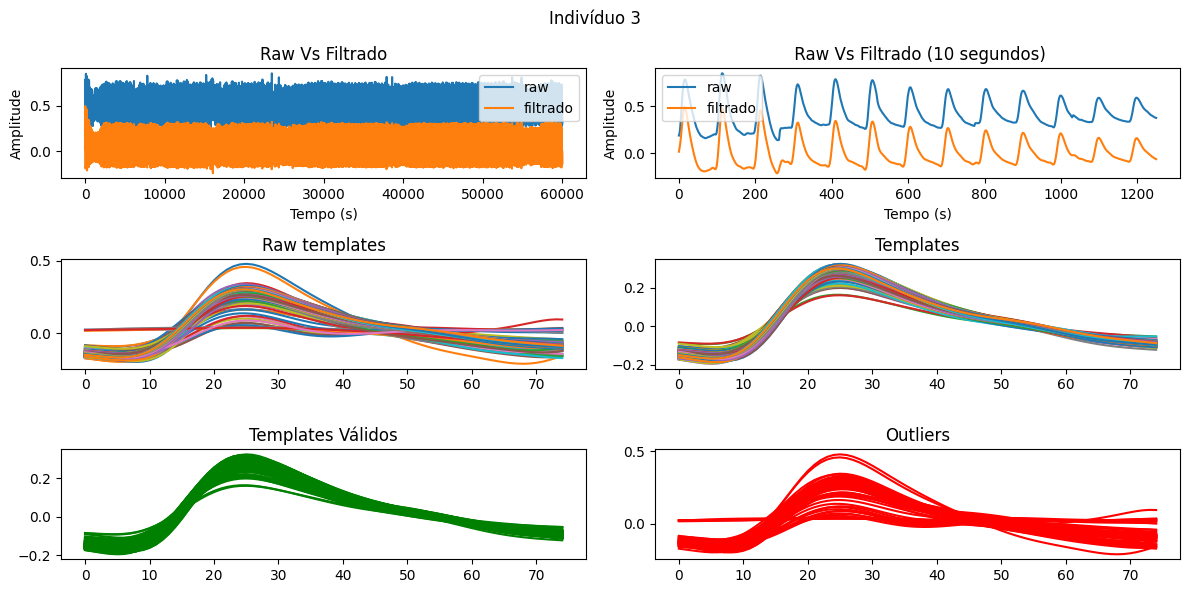

<Figure size 640x480 with 0 Axes>

In [17]:
nIndividuos = 3

for nIndividuo in range(nIndividuos):
    plotSignalDetails(data[nIndividuo])


<a name="template-selection"></a>
## Template Selection

Mínimo de templates: 41 (indivíduo 28)
Máximo de templates: 808 (indivíduo 52)
Limite:  None


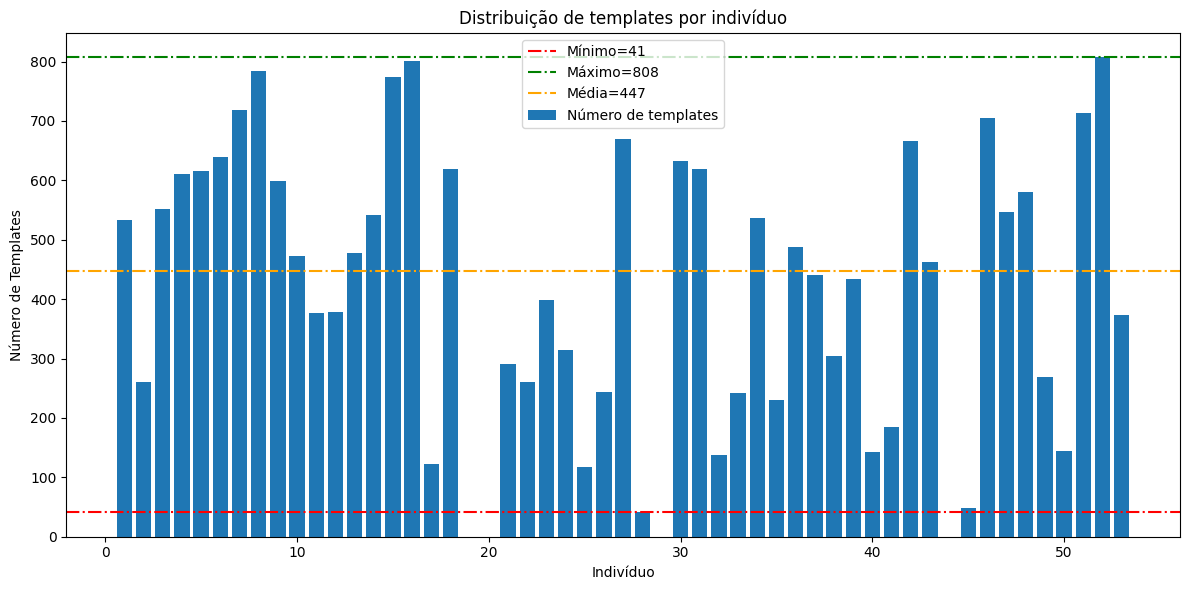

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53]
Normalizando templates do indivíduo 1
Templates do indivíduo 1: 534
Normalizando templates do indivíduo 2
Templates do indivíduo 2: 260
Normalizando templates do indivíduo 3
Templates do indivíduo 3: 552
Normalizando templates do indivíduo 4
Templates do indivíduo 4: 610
Normalizando templates do indivíduo 5
Templates do indivíduo 5: 615
Normalizando templates do indivíduo 6
Templates do indivíduo 6: 639
Normalizando templates do indivíduo 7
Templates do indivíduo 7: 718
Normalizando templates do indivíduo 8
Templates do indivíduo 8: 784
Normalizando templates do indivíduo 9
Templates do indivíduo 9: 599
Normalizando templates do indivíduo 10
Templates do indivíduo 10: 472
Normalizando templates do indivíduo 11
Templates do indivíduo 11: 377
Normalizando templates do indivíduo 12
Templates do indivídu

<Figure size 640x480 with 0 Axes>

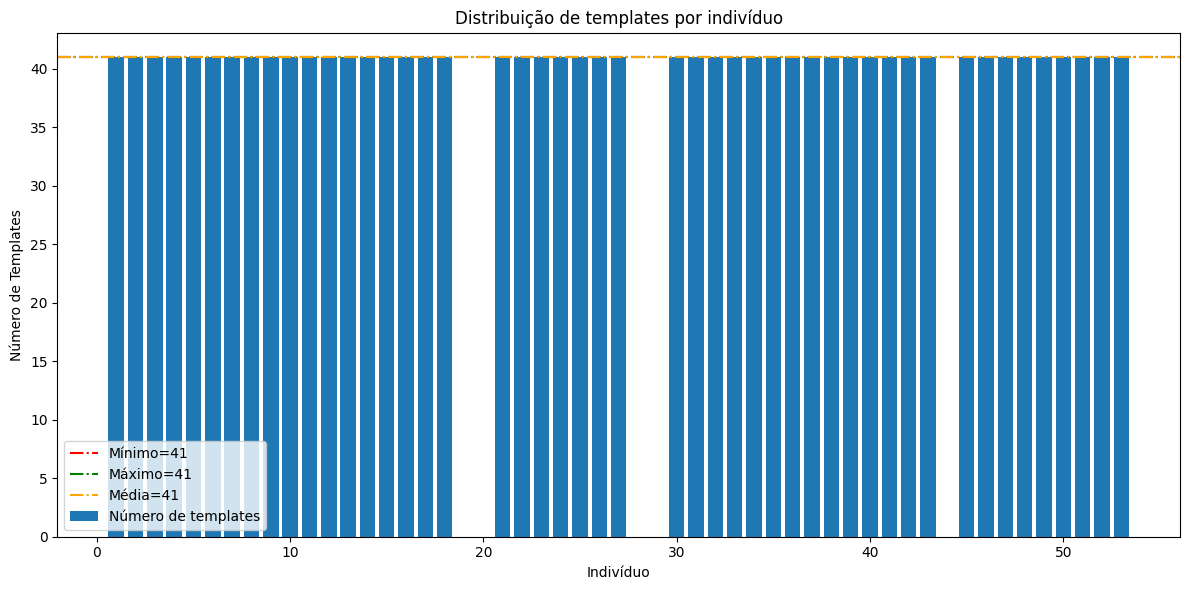

(41, 41, 41)

<Figure size 640x480 with 0 Axes>

In [18]:
data = [individuo for individuo in data if "templates" in individuo.keys() and individuo['templates'] is not None]

min, _, _ = plotTemplatesHistogram(data)

print([individuo['subject'] for individuo in data])

limite = min

not_to_enroll = []
## Normalização dos templates por indivíduo
for individuo in data:
    print(f"Normalizando templates do indivíduo {individuo['subject']}")
    rd.shuffle(individuo['templates'])

    print(f"Templates do indivíduo {individuo['subject']}: {len(individuo['templates'])}")
    if len(individuo['templates']) > limite:
        individuo.update({'templates': individuo['templates'][:limite]})
    else:
        print(f"Indivíduo {individuo['subject']} não possui templates suficientes")
        not_to_enroll.append(individuo['subject'])

data = [individuo for individuo in data if individuo['subject'] not in not_to_enroll]

print([individuo['subject'] for individuo in data])
plotTemplatesHistogram(data, limite=limite)

<a name="domínio-do-problema"></a>
## Domínio do Problema

#### Conversão dos templates nos dados de input de treino e teste da rede

In [19]:
X = []
Y = []
for individuo in data: 
    for template in individuo['templates']:
        X.append(template)
        Y.append(int(individuo['subject']))

X = np.array(X)
Y = np.array(Y)

<a name="problema-multiclasse"></a>
## Problema Multiclasse

### Modelo

In [20]:
# Define parameters
N = 32        # Number of filters per Conv1D layer
L1, L2, L3 = 5, 10, 15  # Filter lengths
M = 128       # Number of units in the dense layer

# Input layer for raw PPG signals
input_signal = Input(shape=(None, 1), name='raw_ppg_input')

# Parallel convolutional layers with different filter lengths
conv1 = Conv1D(filters=N, kernel_size=L1, activation='relu')(input_signal)
conv2 = Conv1D(filters=N, kernel_size=L2, activation='relu')(input_signal)
conv3 = Conv1D(filters=N, kernel_size=L3, activation='relu')(input_signal)

# Global max pooling for each convolutional output
pool1 = GlobalMaxPooling1D()(conv1)
pool2 = GlobalMaxPooling1D()(conv2)
pool3 = GlobalMaxPooling1D()(conv3)

# Concatenate the pooled features into a single feature vector
concatenated_features = Concatenate()([pool1, pool2, pool3])

# Dense layer for classification
dense_layer = Dense(3 * N * M, activation='relu')(concatenated_features)

# Output layer with a single neuron for binary classification
#output = Dense(1, activation='sigmoid')(dense_layer)

# Output layer with a 53 neurons for multiclasse classification
output = Dense(54, activation='softmax')(dense_layer)

# Build the model
model = Model(inputs=input_signal, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary for inspection
model.summary()

model.save('modelo/multi_ppg.keras')




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ raw_ppg_input       │ (None, None, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, None, 32)  │        192 │ raw_ppg_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, None, 32)  │        352 │ raw_ppg_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, None, 32)  │        512 │ raw_ppg_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 12288)     │  1,191,936 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 54)        │    663,606 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,856,598 (7.08 MB)

 Trainable params: 1,856,598 (7.08 MB)

 Non-trainable params: 0 (0.00 B)

##### Formulating Multiclasse Problem

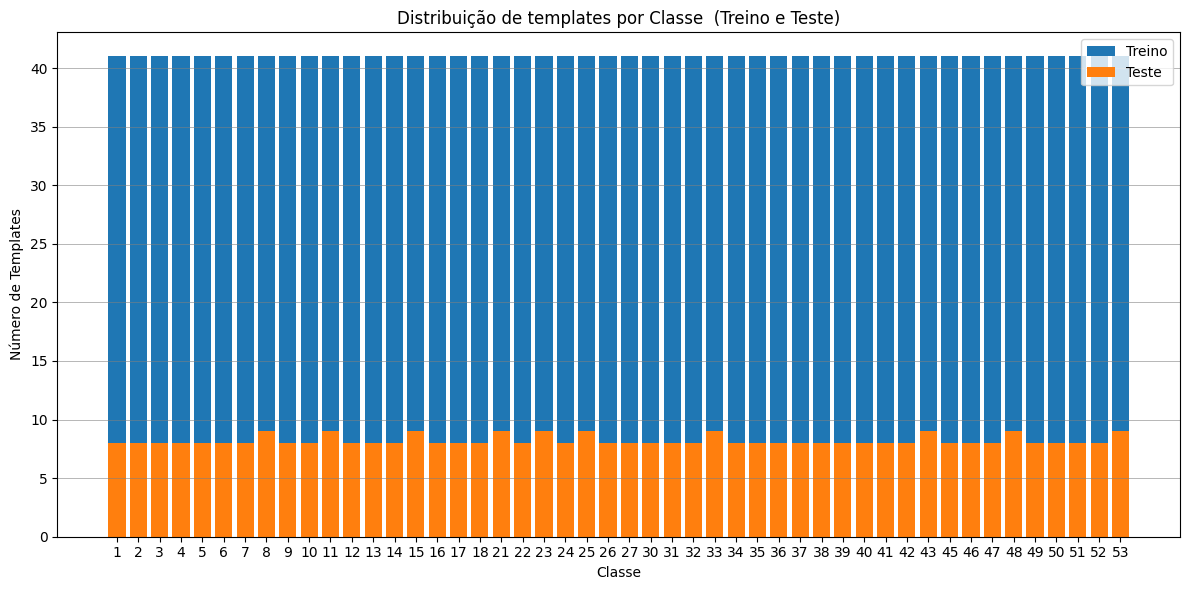

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y, shuffle=True)

plt.figure(figsize=(12, 6))
plt.bar([str(i) for i in np.unique(Y)], [np.sum(Y==i) for i in np.unique(Y)], label='Treino')
plt.bar([str(i) for i in np.unique(y_test)], [np.sum(y_test==i) for i in np.unique(y_test)], label='Teste')
plt.title('Distribuição de templates por Classe  (Treino e Teste)')
plt.xlabel('Classe')
plt.ylabel('Número de Templates')
plt.legend()
plt.grid(axis='y', color='grey', alpha=0.8, linestyle='-', linewidth=0.5)
plt.grid(axis='x', visible=False)
plt.tight_layout()
plt.show()

<a name="treino"></a>
### Treino

In [22]:
y_train_enc = to_categorical(y_train, num_classes=54)
y_test_enc = to_categorical(y_test, num_classes=54)

X_train_padded = pad_sequences(X_train, padding='post', dtype='float32')

history = model.fit(X_train_padded, y_train_enc, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0238 - loss: 0.3406 - val_accuracy: 0.0254 - val_loss: 0.1186
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0217 - loss: 0.1111 - val_accuracy: 0.0190 - val_loss: 0.1038
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0087 - loss: 0.1004 - val_accuracy: 0.0190 - val_loss: 0.0910
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0306 - loss: 0.0881 - val_accuracy: 0.0508 - val_loss: 0.0825
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0629 - loss: 0.0824 - val_accuracy: 0.0571 - val_loss: 0.0804
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0886 - loss: 0.0809 - val_accuracy: 0.0857 - val_loss: 0.0798
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0798 - loss: 0.0805 - val_accuracy: 0.1206 - val_loss: 0.0779
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1024 - loss: 0.0786 - val_accuracy: 0.

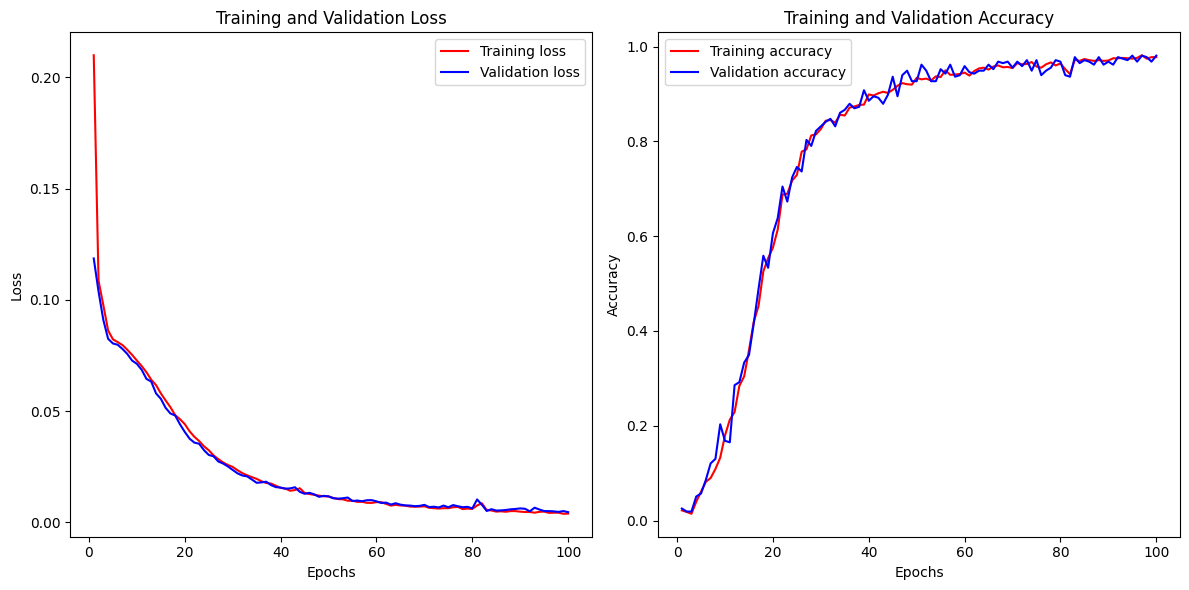

<Figure size 640x480 with 0 Axes>

In [23]:
plotModelHistory(history, type='multi')

#### Guardar Base de Dados

In [24]:
import pickle
with open('database/data.pkl', 'wb') as file:
    pickle.dump(data, file)

<a name="teste"></a>
### Teste

In [25]:
X_test_padded = pad_sequences(X_test, padding='post', dtype='float32')

y_pred = model.predict(X_test_padded)

print(y_pred.shape)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(394, 54)


<a name="avaliação"></a>
### Avaliação

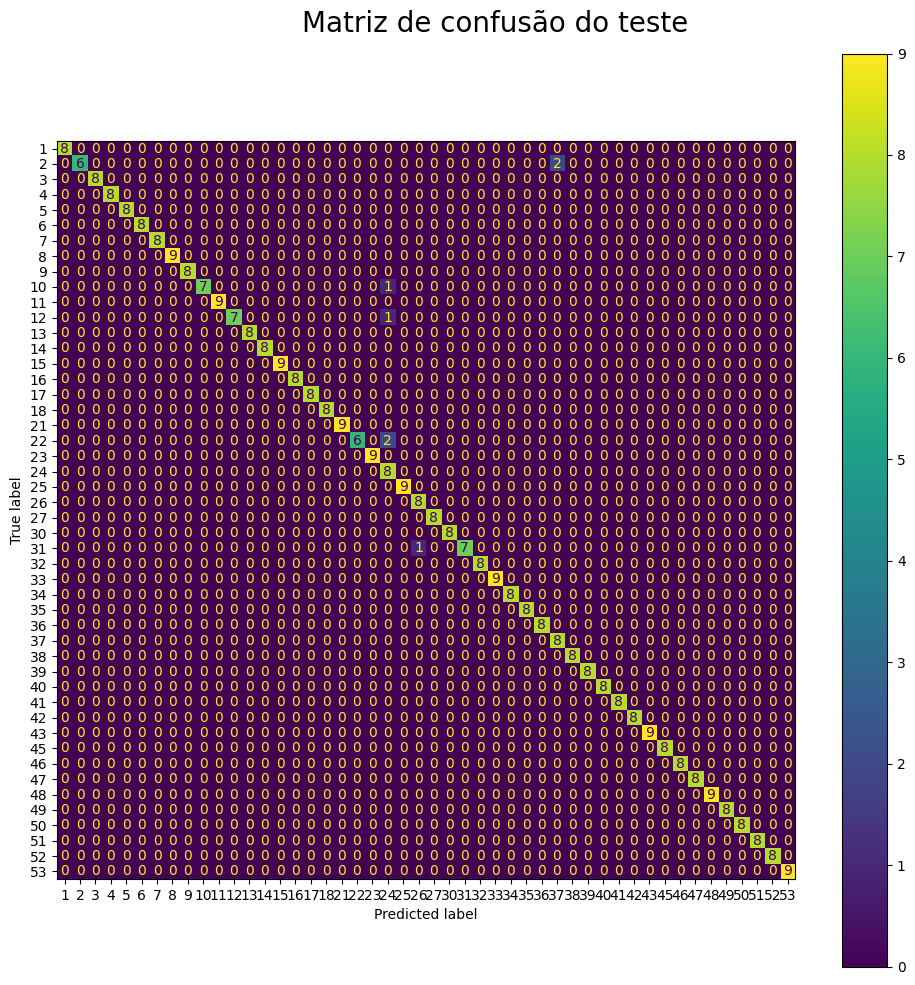

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         8
           2       1.00      0.75      0.86         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00         8
          10       1.00      0.88      0.93         8
          11       1.00      1.00      1.00         9
          12       1.00      0.88      0.93         8
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         8
          15       1.00      1.00      1.00         9
          16       1.00      1.00      1.00         8
          17       1.00      1.00      1.00         8
          18       1.00    

<Figure size 640x480 with 0 Axes>

In [26]:

# Convert predictions to binary (0 or 1) with threshold 0.5
y_pred_fin = np.argmax(y_pred, axis=1)

plotConfusionMatrix(y_test, y_pred_fin, type='multi')

# # Compute the confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred_fin)
# matrix = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y_test))
# fig, ax = plt.subplots(figsize=(20,20))
# fig.suptitle('Matriz de confusão do teste', fontsize=20)
# matrix.plot(ax=ax, cmap='viridis')
# plt.grid(False)
# plt.tight_layout()
# plt.show();

print(classification_report(y_test, y_pred_fin))

<a name="problema-binário"></a>
## Problema Binário

### Modelo

In [27]:
# Define parameters
N = 32        # Number of filters per Conv1D layer
L1, L2, L3 = 5, 10, 15  # Filter lengths
M = 128       # Number of units in the dense layer

# Input layer for raw PPG signals
input_signal = Input(shape=(None, 1), name='raw_ppg_input')

# Parallel convolutional layers with different filter lengths
conv1 = Conv1D(filters=N, kernel_size=L1, activation='relu')(input_signal)
conv2 = Conv1D(filters=N, kernel_size=L2, activation='relu')(input_signal)
conv3 = Conv1D(filters=N, kernel_size=L3, activation='relu')(input_signal)

# Global max pooling for each convolutional output
pool1 = GlobalMaxPooling1D()(conv1)
pool2 = GlobalMaxPooling1D()(conv2)
pool3 = GlobalMaxPooling1D()(conv3)

# Concatenate the pooled features into a single feature vector
concatenated_features = Concatenate()([pool1, pool2, pool3])

# Dense layer for classification
dense_layer = Dense(3 * N * M, activation='relu')(concatenated_features)

# Output layer with a single neuron for binary classification
#output = Dense(1, activation='sigmoid')(dense_layer)

# Output layer with a 53 neurons for multiclasse classification
output = Dense(1, activation='sigmoid')(dense_layer)

# Build the model
bin_model = Model(inputs=input_signal, outputs=output)

# Compile the model
bin_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary for inspection
bin_model.summary()

bin_model.save('modelo/bin_ppg.keras')



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ raw_ppg_input       │ (None, None, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, None, 32)  │        192 │ raw_ppg_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, None, 32)  │        352 │ raw_ppg_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, None, 32)  │        512 │ raw_ppg_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_4[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv1d_5[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 96)        │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 12288)     │  1,191,936 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │     12,289 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,205,281 (4.60 MB)

 Trainable params: 1,205,281 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

#### Formulation Binary Problem

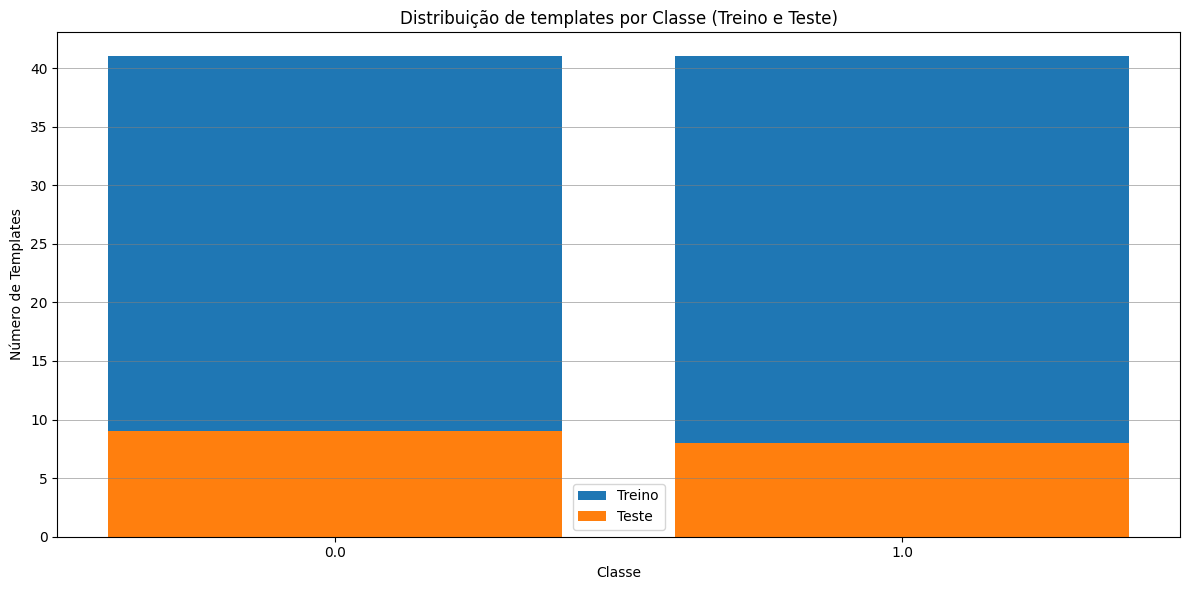

In [28]:
trueClassLabel = 1

Y_bin = (Y == trueClassLabel)*1.

limite = np.sum(Y_bin == 1)

Y_bin_pos = Y_bin[Y_bin == 1]
Y_bin_neg = Y_bin[Y_bin == 0][:limite]

X_pos = X[Y_bin == 1]
X_neg = X[Y_bin == 0][:limite]

X_bin = np.concatenate([X_pos, X_neg])
Y_bin = np.concatenate([Y_bin_pos, Y_bin_neg])



X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_bin, Y_bin, test_size=0.2, random_state=42, stratify=Y_bin, shuffle=True)

plt.figure(figsize=(12, 6))
plt.bar([str(i) for i in np.unique(Y_bin)], [np.sum(Y_bin==i) for i in np.unique(Y_bin)], label='Treino')
plt.bar([str(i) for i in np.unique(y_test_bin)], [np.sum(y_test_bin==i) for i in np.unique(y_test_bin)], label='Teste')
plt.title('Distribuição de templates por Classe (Treino e Teste)')
plt.xlabel('Classe')
plt.ylabel('Número de Templates')
plt.legend()
plt.grid(axis='y', color='grey', alpha=0.8, linestyle='-', linewidth=0.5)
plt.grid(axis='x', visible=False)
plt.tight_layout()
plt.show()


<a name="treino-1"></a>
### Treino

In [29]:
X_train_bin_padded = pad_sequences(X_train_bin, padding='post', dtype='float32')

history_bin = bin_model.fit(X_train_bin_padded, np.array(y_train_bin), epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.5817 - loss: 0.6882 - val_accuracy: 0.4615 - val_loss: 0.6716
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4896 - loss: 0.6604 - val_accuracy: 0.4615 - val_loss: 0.6647
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4896 - loss: 0.6464 - val_accuracy: 0.4615 - val_loss: 0.6547
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5312 - loss: 0.6116 - val_accuracy: 0.4615 - val_loss: 0.6367
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5208 - loss: 0.5944 - val_accuracy: 0.4615 - val_loss: 0.6059
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5417 - loss: 0.5558 - val_accuracy: 0.4615 - val_loss: 0.5725
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5304 - loss: 0.5540 - val_accuracy: 1.0000 - val_loss: 0.5408
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9535 - loss: 0.5225 - val_accuracy: 1.0000 - val_los

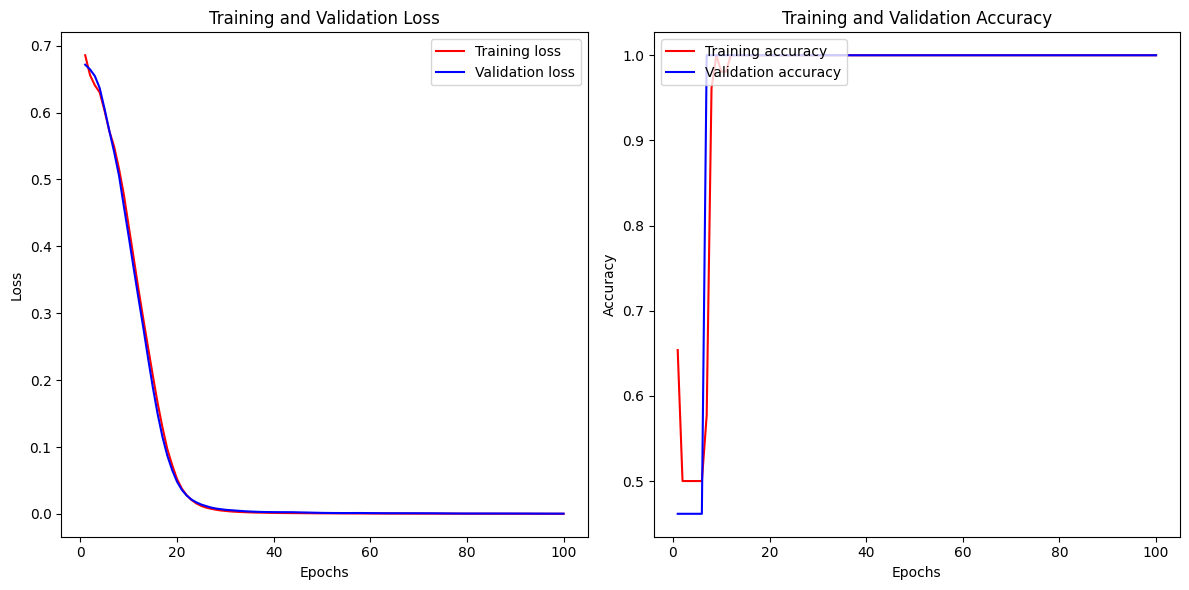

<Figure size 640x480 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt

plotModelHistory(history_bin, type='bin')

<a name="teste-1"></a>
### Teste

In [31]:
X_test_bin_padded = pad_sequences(X_test_bin, padding='post', dtype='float32')

y_bin_pred = bin_model.predict(X_test_bin_padded)

print(y_bin_pred.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
(17, 1)


<a name="avaliação-1"></a>
### Avaliação

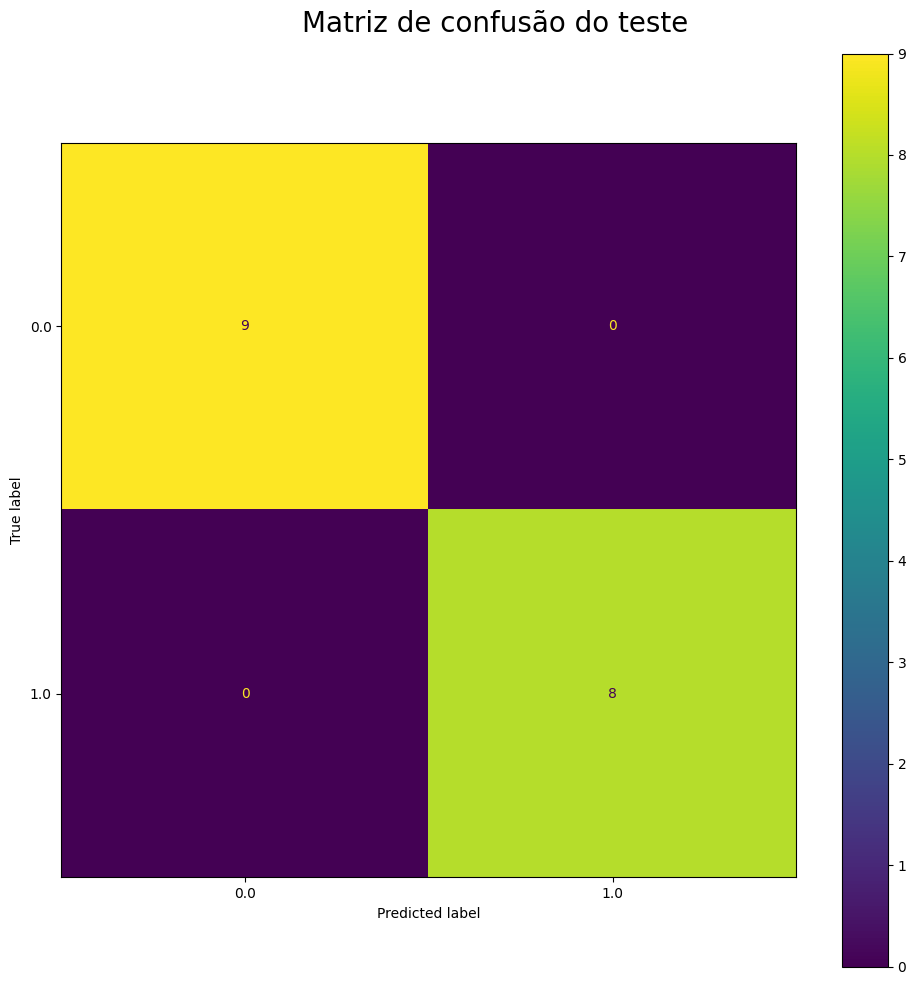

<Figure size 640x480 with 0 Axes>

In [32]:
y_bin_pred_fin = (y_bin_pred > 0.5)*1.

plotConfusionMatrix(y_test_bin, y_bin_pred_fin, type='bin')

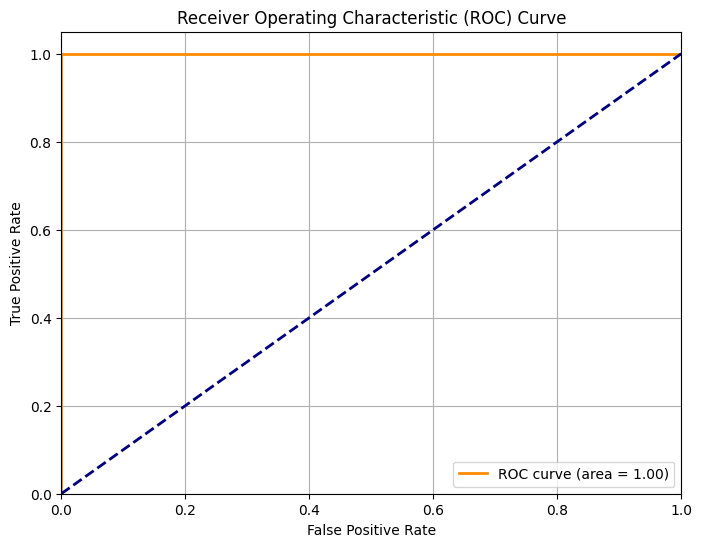

<Figure size 640x480 with 0 Axes>

In [33]:
plotROCCurves(y_test_bin, y_bin_pred)